# Predykcja choroby serca z wykorzystaniem metod uczenia maszynowego

Temat 3

Projekt polega na zastosowaniu metod uczenia maszynowego do klasyfikacji przypadków choroby serca na podstawie danych klinicznych i behawioralnych pacjentów. W projekcie wykorzystany jest zestaw danych Heart Disease udostępniony na platformie Kaggle:

https://www.kaggle.com/datasets/oktayrdeki/heart-disease

Zbiór danych ma postać tabelaryczną i zawiera różne wskaźniki zdrowotne oraz czynniki ryzyka związane z chorobami układu krążenia. Do typowych cech należą m.in. wiek, płeć, ciśnienie krwi, poziom cholesterolu, wskaźniki glukozy, aktywność fizyczna oraz inne parametry kliniczne. Zmienna decyzyjna odzwierciedla, czy u danej osoby stwierdzono chorobę serca (wartość binarna: występowanie / brak występowania).

Celem projektu jest opracowanie modelu uczenia maszynowego, który umożliwia predykcję ryzyka choroby serca w oparciu o dostępne dane pacjenta. Projekt obejmuje analizę i przygotowanie danych, implementację wybranych klasyfikatorów oraz ocenę ich skuteczności. Rozwiązanie demonstruje praktyczne zastosowanie uczenia maszynowego w analizie danych medycznych oraz problemy związane z budową modeli predykcyjnych w kontekście medycznym.

W pierwszym etapie przeprowadzana jest eksploracja danych oraz ich przygotowanie do modelowania, obejmujące m.in. obsługę braków danych i kodowanie zmiennych kategorycznych. Następnie implementowane są wybrane algorytmy klasyfikacyjne, a ich jakość oceniana jest za pomocą miar takich jak accuracy, precision i recall. Ostateczna interpretacja wyników uwzględnia wpływ poszczególnych cech na jakość predykcji oraz ograniczenia modelu wynikające z charakteru zbioru danych.

Efektem projektu jest działający system predykcyjny wraz z raportem przedstawiającym przebieg prac, zastosowane metody oraz wnioski dotyczące efektywności modelu.

## 1. Instalacja zależności i konfiguracja środowiska

In [1]:
%pip install -q pandas "numpy<2.4" matplotlib seaborn scikit-learn tensorflow shap

In [2]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import shap

RANDOM_STATE = 42
DATA_PATH = pathlib.Path("data.csv")

## 2. Wczytanie danych i podstawowy podgląd

In [3]:
df = pd.read_csv(DATA_PATH)

print(df.shape)

df_info = df.info()
df_sample = df.sample(5, random_state=RANDOM_STATE)

df_sample

(10000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9971 non-null   float64
 1   Gender                9981 non-null   object 
 2   Blood Pressure        9981 non-null   float64
 3   Cholesterol Level     9970 non-null   float64
 4   Exercise Habits       9975 non-null   object 
 5   Smoking               9975 non-null   object 
 6   Family Heart Disease  9979 non-null   object 
 7   Diabetes              9970 non-null   object 
 8   BMI                   9978 non-null   float64
 9   High Blood Pressure   9974 non-null   object 
 10  Low HDL Cholesterol   9975 non-null   object 
 11  High LDL Cholesterol  9974 non-null   object 
 12  Alcohol Consumption   7414 non-null   object 
 13  Stress Level          9978 non-null   object 
 14  Sleep Hours           9975 non-null   float64
 15  Sugar Co

,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,...,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
6252,38.0,Male,169.0,156.0,Medium,Yes,No,Yes,35.303549,No,...,Yes,Medium,High,4.213721,Medium,321.0,158.0,9.778347,17.400056,No
4684,77.0,Female,174.0,280.0,Medium,Yes,Yes,No,29.792178,Yes,...,Yes,NaN,Medium,5.081128,Medium,312.0,80.0,14.370456,8.724180,No
1731,20.0,Male,177.0,295.0,Medium,No,NaN,No,36.114431,No,...,Yes,NaN,Low,8.289710,Medium,249.0,150.0,0.449952,14.448030,No
4742,73.0,Female,133.0,255.0,High,No,Yes,Yes,32.606449,Yes,...,Yes,Medium,High,8.285570,High,187.0,151.0,3.316559,6.295346,No
4521,66.0,Male,151.0,197.0,Low,No,No,Yes,27.631877,Yes,...,No,Medium,High,9.646179,Medium,308.0,128.0,6.696756,7.550089,No


## 3. Eksploracja danych i statystyki opisowe

In [4]:
df_desc = df.describe(include="all")
display(df_desc)

target_col = "Heart Disease Status"

print("\n=== Rozkład zmiennej docelowej ===")
print(df[target_col].value_counts(dropna=False))

print(f"\n=== Proporcja klas ===\n{df[target_col].value_counts(normalize=True, dropna=False)}")

print("\n=== Typy danych ===")
print(df.dtypes)

,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,...,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
count,9971.000000,9981,9981.000000,9970.000000,9975,9975,9979,9970,9978.000000,9974,...,9974,7414,9978,9975.000000,9970,9974.000000,9978.000000,9974.000000,9980.000000,10000
unique,NaN,2,NaN,NaN,3,2,2,2,NaN,2,...,2,3,3,NaN,3,NaN,NaN,NaN,NaN,2
top,NaN,Male,NaN,NaN,High,Yes,No,No,NaN,Yes,...,No,Medium,Medium,NaN,Low,NaN,NaN,NaN,NaN,No
freq,NaN,5003,NaN,NaN,3372,5123,5004,5018,NaN,5022,...,5036,2500,3387,NaN,3390,NaN,NaN,NaN,NaN,8000
mean,49.296259,NaN,149.757740,225.425577,NaN,NaN,NaN,NaN,29.077269,NaN,...,NaN,NaN,NaN,6.991329,NaN,250.734409,120.142213,7.472201,12.456271,NaN
std,18.193970,NaN,17.572969,43.575809,NaN,NaN,NaN,NaN,6.307098,NaN,...,NaN,NaN,NaN,1.753195,NaN,87.067226,23.584011,4.340248,4.323426,NaN
min,18.000000,NaN,120.000000,150.000000,NaN,NaN,NaN,NaN,18.002837,NaN,...,NaN,NaN,NaN,4.000605,NaN,100.000000,80.000000,0.003647,5.000236,NaN
25%,34.000000,NaN,134.000000,187.000000,NaN,NaN,NaN,NaN,23.658075,NaN,...,NaN,NaN,NaN,5.449866,NaN,176.000000,99.000000,3.674126,8.723334,NaN
50%,49.000000,NaN,150.000000,226.000000,NaN,NaN,NaN,NaN,29.079492,NaN,...,NaN,NaN,NaN,7.003252,NaN,250.000000,120.000000,7.472164,12.409395,NaN
75%,65.000000,NaN,165.000000,263.000000,NaN,NaN,NaN,NaN,34.520015,NaN,...,NaN,NaN,NaN,8.531577,NaN,326.000000,141.000000,11.255592,16.140564,NaN



=== Rozkład zmiennej docelowej ===
Heart Disease Status
No     8000
Yes    2000
Name: count, dtype: int64

=== Proporcja klas ===
Heart Disease Status
No     0.8
Yes    0.2
Name: proportion, dtype: float64

=== Typy danych ===
Age                     float64
Gender                   object
Blood Pressure          float64
Cholesterol Level       float64
Exercise Habits          object
Smoking                  object
Family Heart Disease     object
Diabetes                 object
BMI                     float64
High Blood Pressure      object
Low HDL Cholesterol      object
High LDL Cholesterol     object
Alcohol Consumption      object
Stress Level             object
Sleep Hours             float64
Sugar Consumption        object
Triglyceride Level      float64
Fasting Blood Sugar     float64
CRP Level               float64
Homocysteine Level      float64
Heart Disease Status     object
dtype: object


## 4. Kontrola braków danych i outlierów

=== Liczba braków danych ===
Alcohol Consumption     2586
Diabetes                  30
Sugar Consumption         30
Cholesterol Level         30
Age                       29
Triglyceride Level        26
CRP Level                 26
High LDL Cholesterol      26
High Blood Pressure       26
Low HDL Cholesterol       25
Sleep Hours               25
Exercise Habits           25
Smoking                   25
Fasting Blood Sugar       22
BMI                       22
Stress Level              22
Family Heart Disease      21
Homocysteine Level        20
Blood Pressure            19
Gender                    19
dtype: int64

=== Procent braków danych ===
Age                      0.29
Gender                   0.19
Blood Pressure           0.19
Cholesterol Level        0.30
Exercise Habits          0.25
Smoking                  0.25
Family Heart Disease     0.21
Diabetes                 0.30
BMI                      0.22
High Blood Pressure      0.26
Low HDL Cholesterol      0.25
High LDL Choleste

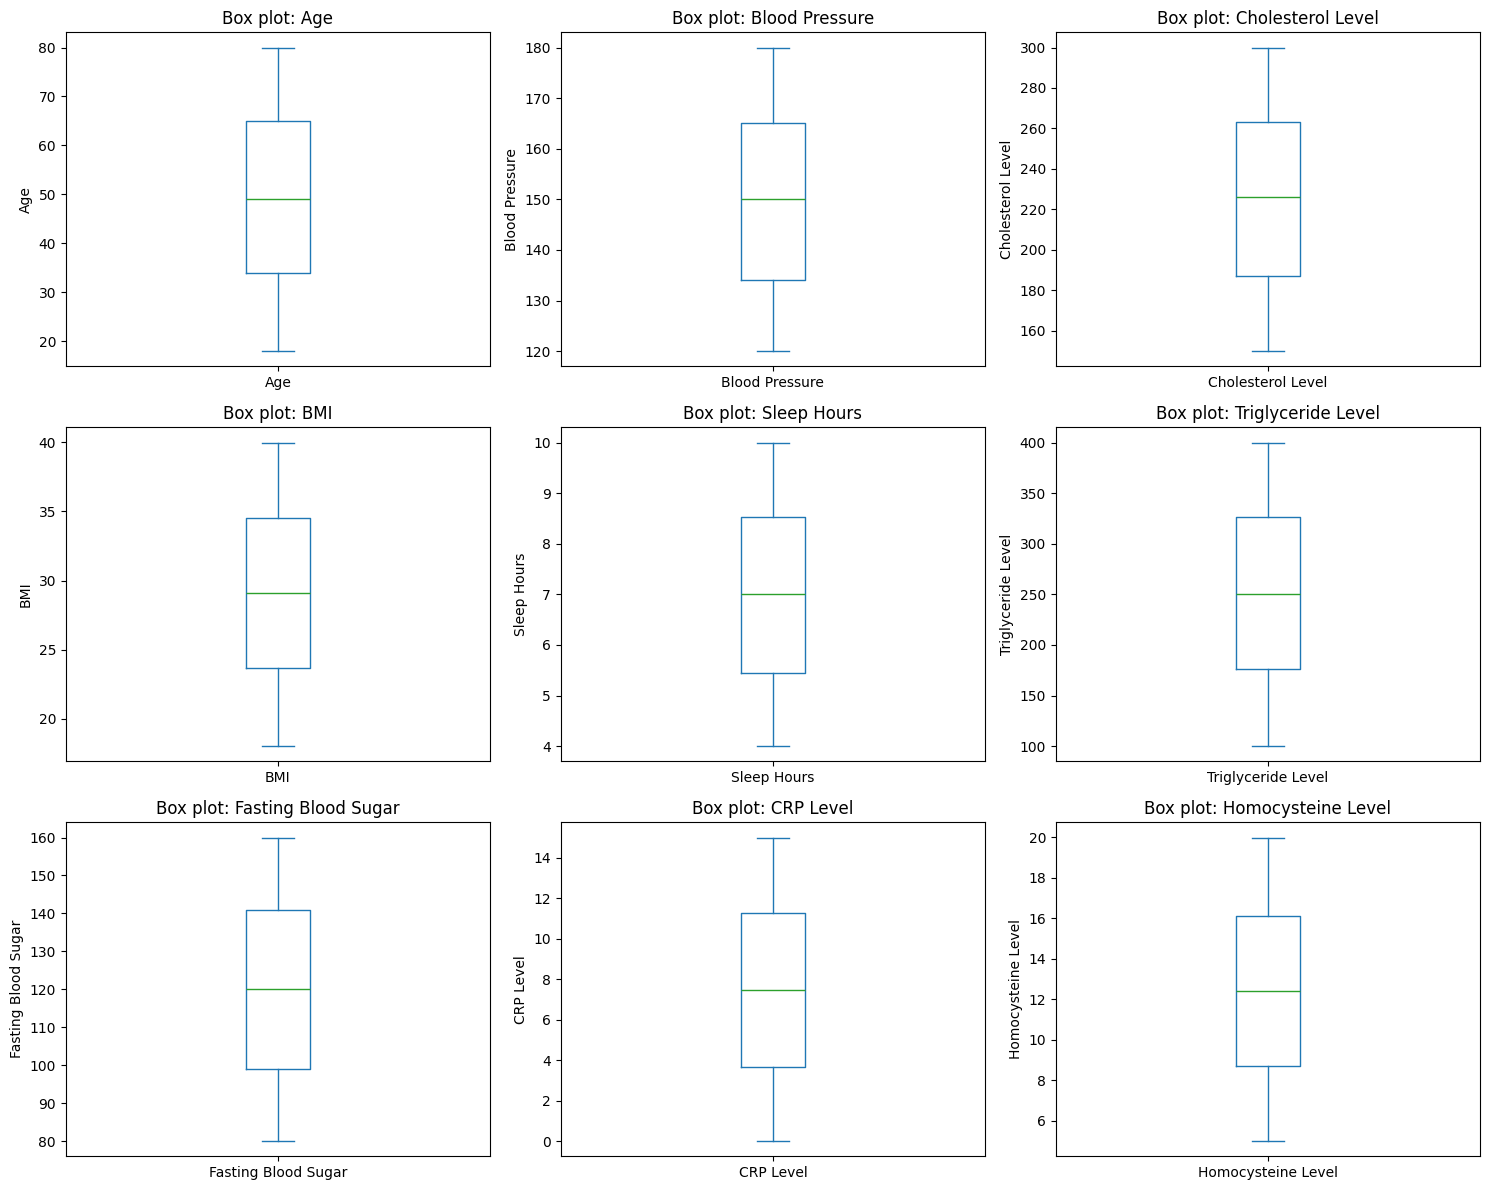

In [5]:
df_clean = df.replace({"": np.nan, "None": np.nan})
missing_counts = df_clean.isnull().sum().sort_values(ascending=False)

print("=== Liczba braków danych ===")
print(missing_counts[missing_counts > 0])

missing_ratio = (df_clean.isnull().mean() * 100).round(2)

print("\n=== Procent braków danych ===")
print(missing_ratio[missing_ratio > 0])

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

num_cols = [
    "Age", "Blood Pressure", "Cholesterol Level", "BMI",
    "Sleep Hours", "Triglyceride Level", "Fasting Blood Sugar",
    "CRP Level", "Homocysteine Level"
]

for idx, col in enumerate(num_cols):
    if col in df_clean.columns:
        df_clean[col].plot(kind='box', ax=axes[idx])
        axes[idx].set_title(f'Box plot: {col}')
        axes[idx].set_ylabel(col)

plt.tight_layout()
plt.show()

## 5. Równoważenie klas przez downsampling

In [6]:
majority = df_clean[df_clean[target_col] == "No"]
minority = df_clean[df_clean[target_col] == "Yes"]

majority_down = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=RANDOM_STATE
)

df_balanced = pd.concat([majority_down, minority]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print("=== Liczebności po downsamplingu ===")
print(df_balanced[target_col].value_counts())

print("\n=== Proporcja ===")
print(df_balanced[target_col].value_counts(normalize=True))

=== Liczebności po downsamplingu ===
Heart Disease Status
No     2000
Yes    2000
Name: count, dtype: int64

=== Proporcja ===
Heart Disease Status
No     0.5
Yes    0.5
Name: proportion, dtype: float64


## 6. Wizualizacje, histogramy i korelacje

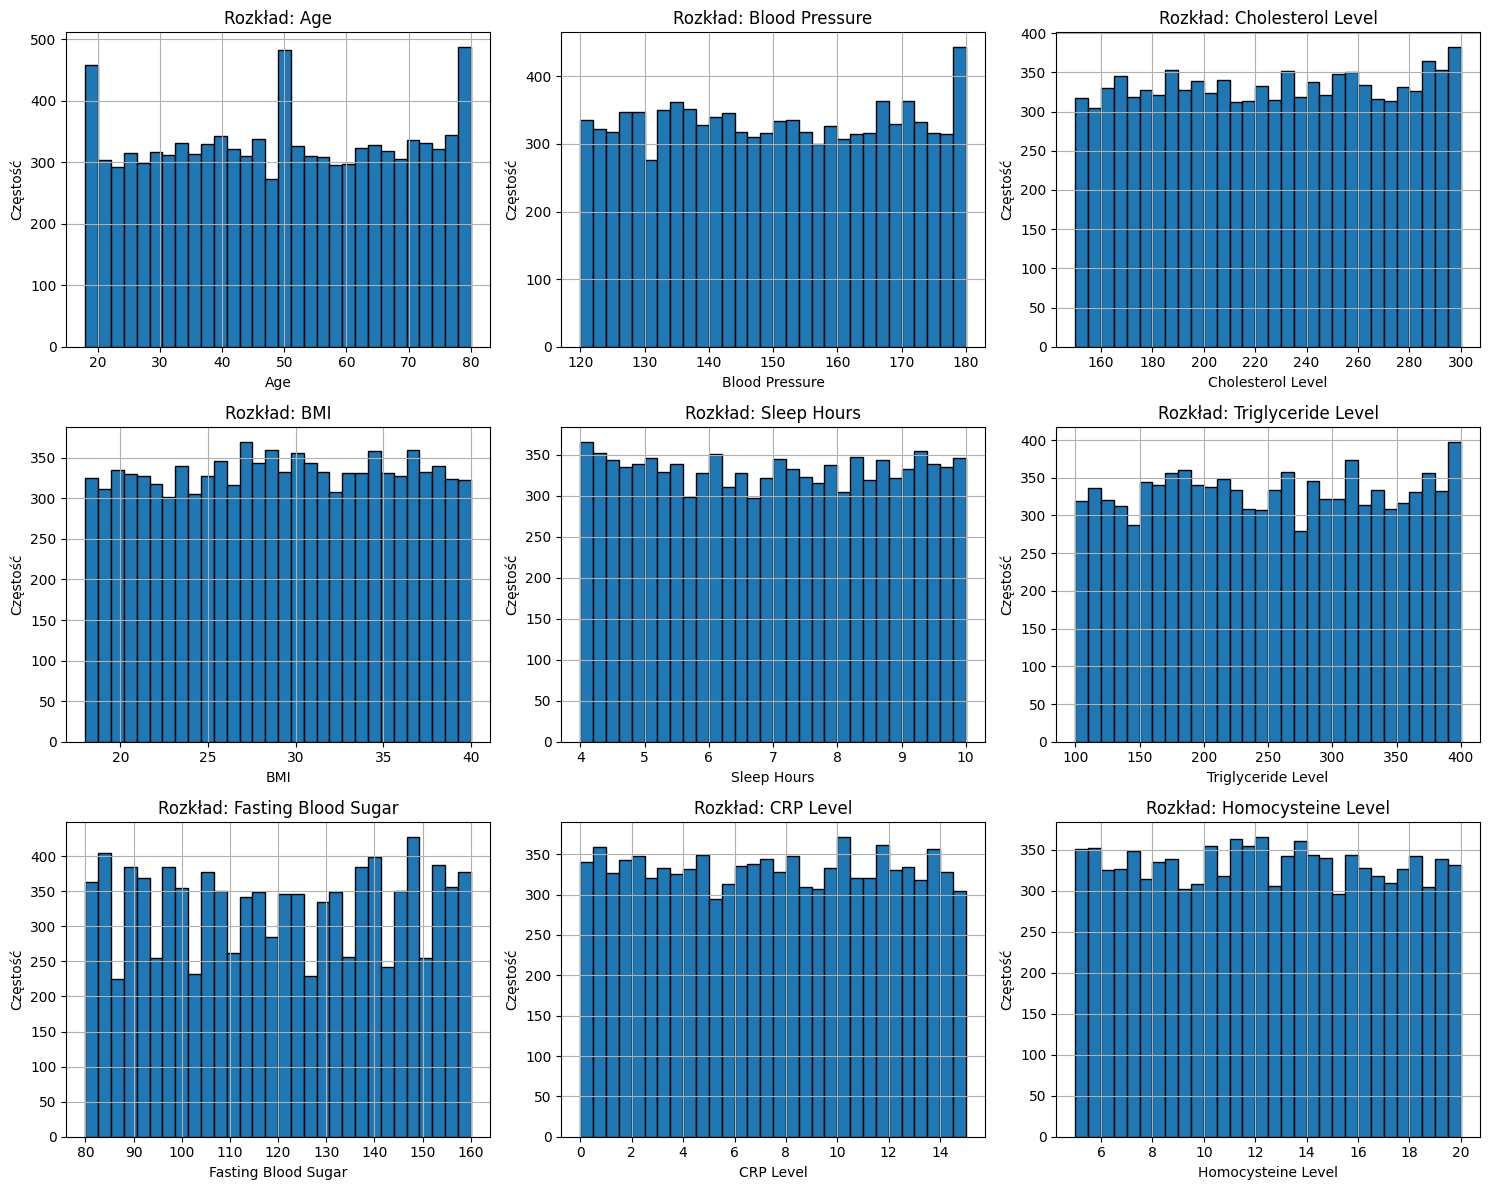


=== Analiza korelacji cech numerycznych ===


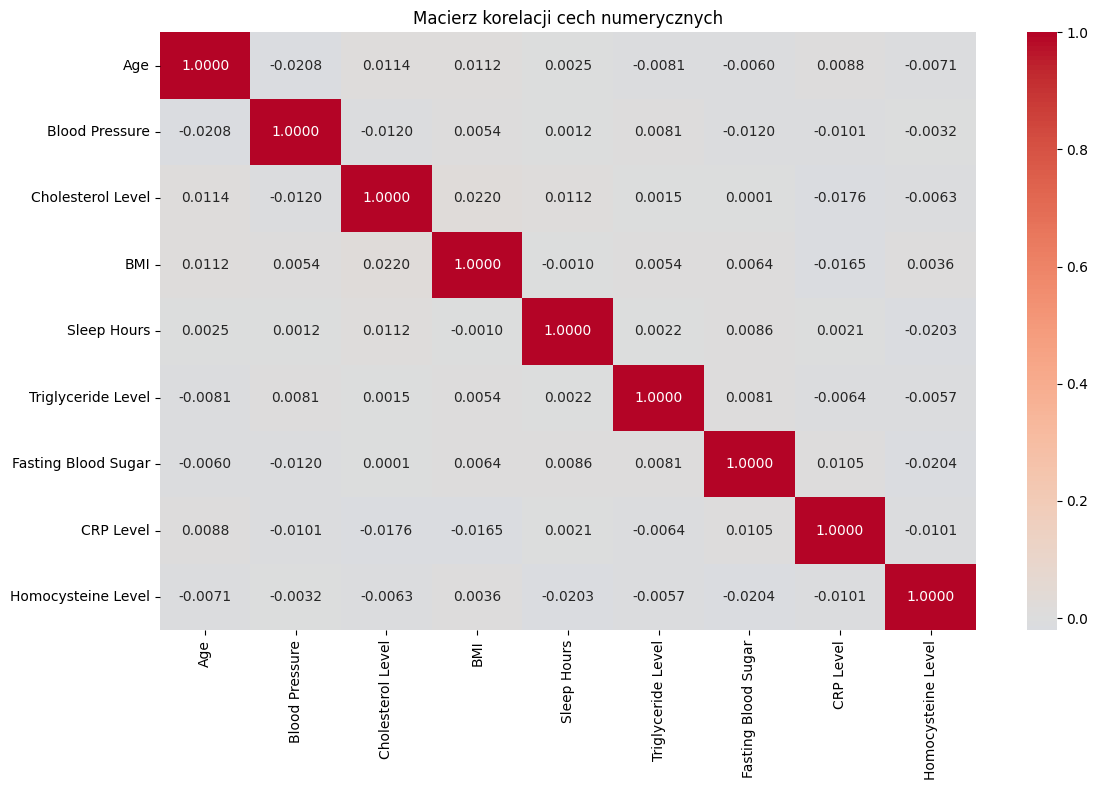


=== Korelacja cech z targetem ===
BMI                    0.019695
Homocysteine Level     0.008301
Triglyceride Level     0.002921
Cholesterol Level      0.002710
Fasting Blood Sugar   -0.002247
Sleep Hours           -0.003819
CRP Level             -0.006020
Age                   -0.009249
Blood Pressure        -0.013890
dtype: float64


In [7]:
num_cols_viz = [
    "Age", "Blood Pressure", "Cholesterol Level", "BMI", "Sleep Hours",
    "Triglyceride Level", "Fasting Blood Sugar", "CRP Level", "Homocysteine Level"
]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(num_cols_viz):
    if col in df_clean.columns:
        df_clean[col].hist(bins=30, ax=axes[idx], edgecolor='black')
        axes[idx].set_title(f'Rozkład: {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Częstość')

plt.tight_layout()
plt.show()

print("\n=== Analiza korelacji cech numerycznych ===")

plt.figure(figsize=(12, 8))
correlation_matrix = df_clean[num_cols_viz].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.4f', cmap='coolwarm', center=0)
plt.title("Macierz korelacji cech numerycznych")
plt.tight_layout()
plt.show()

y_numeric = df_clean[target_col].map({"Yes": 1, "No": 0})
target_corr = df_clean[num_cols_viz].corrwith(y_numeric).sort_values(ascending=False)

print("\n=== Korelacja cech z targetem ===")
print(target_corr)

## 7. Kodowanie zmiennych kategorycznych i skalowanie cech

In [8]:
cat_cols = [
    "Gender", "Exercise Habits", "Smoking", "Family Heart Disease", "Diabetes",
    "High Blood Pressure", "Low HDL Cholesterol", "High LDL Cholesterol",
    "Alcohol Consumption", "Stress Level", "Sugar Consumption"
]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

## 8. Podział na zbiory treningowy i testowy

In [9]:
df_model = df_clean.copy()
# df_model = df_balanced.copy()

X = df_model.drop(columns=[target_col])
y = df_model[target_col].map({"Yes": 1, "No": 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(y_train.value_counts())
print(f"\n{y_train.value_counts(normalize=True)}")

print(y_test.value_counts())
print(f"\n{y_test.value_counts(normalize=True)}")

X_train.shape, X_test.shape

Heart Disease Status
0    6400
1    1600
Name: count, dtype: int64

Heart Disease Status
0    0.8
1    0.2
Name: proportion, dtype: float64
Heart Disease Status
0    1600
1     400
Name: count, dtype: int64

Heart Disease Status
0    0.8
1    0.2
Name: proportion, dtype: float64


((8000, 20), (2000, 20))

## 9. Porównanie klasyfikatorów i dostrajanie hiperparametrów

### RandomForest

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Najlepsze parametry RandomForest:
  {'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 1}
  Best CV ROC-AUC: 0.5154

Test Set Metrics (Best RF):
  Accuracy: 0.5375
  Precision: 0.1810
  Recall: 0.3725
  F1: 0.2437
  ROC-AUC: 0.4713


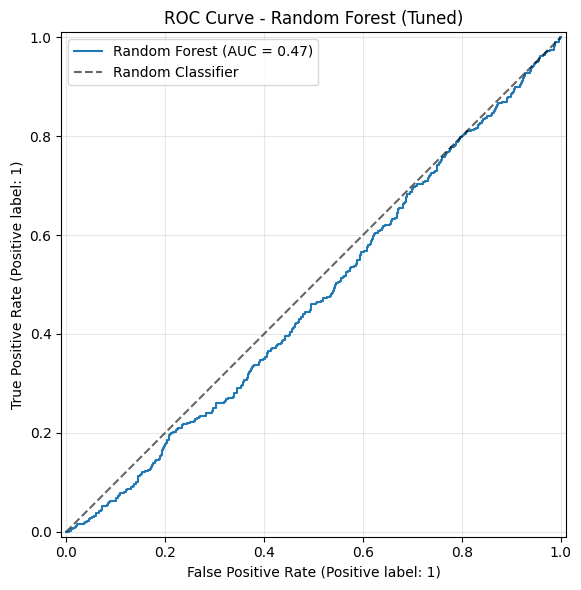

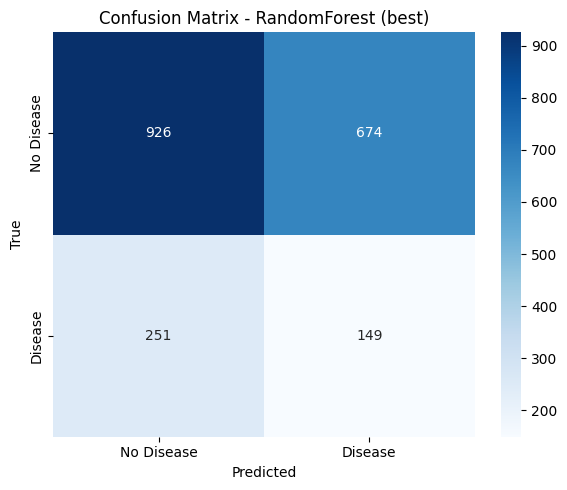


=== Classification Report (Best RF) ===
              precision    recall  f1-score   support

  No Disease      0.787     0.579     0.667      1600
     Disease      0.181     0.372     0.244       400

    accuracy                          0.537      2000
   macro avg      0.484     0.476     0.455      2000
weighted avg      0.666     0.537     0.582      2000


=== Top 100 RandomForest Konfiguracji (wg CV ROC-AUC) ===


,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__class_weight,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_accuracy
4,entropy,3,1,balanced,0.515367,0.018045,1,0.209878,0.445625,0.285162,0.553500
5,entropy,3,3,balanced,0.515342,0.018257,2,0.209537,0.445000,0.284772,0.553125
0,gini,3,1,balanced,0.514396,0.016527,3,0.211137,0.437500,0.284606,0.560625
1,gini,3,3,balanced,0.514315,0.016591,4,0.211202,0.435625,0.284318,0.562000
6,entropy,None,1,balanced,0.511317,0.023719,5,0.000000,0.000000,0.000000,0.800000
7,entropy,None,3,balanced,0.505839,0.016109,6,0.000000,0.000000,0.000000,0.800000
3,gini,None,3,balanced,0.502569,0.010772,7,0.000000,0.000000,0.000000,0.800000
2,gini,None,1,balanced,0.494683,0.008960,8,0.000000,0.000000,0.000000,0.800000


In [ ]:
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
])

param_grid_pipeline = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, None],
    'clf__min_samples_leaf': [1, 3],
    'clf__class_weight': ['balanced']
}

grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_pipeline,
    cv=5,
    scoring=['roc_auc', 'precision', 'recall', 'f1', 'accuracy'],
    refit='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

print(f"\nNajlepsze parametry RandomForest:")
print(f"  {grid_search_rf.best_params_}")
print(f"  Best CV ROC-AUC: {grid_search_rf.best_score_:.4f}")

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

print(f"\nTest Set Metrics (Best RF):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf, zero_division=0):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_rf, zero_division=0):.4f}")
print(f"  F1: {f1_score(y_test, y_pred_rf, zero_division=0):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_prob_rf, ax=ax, name='Random Forest')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Classifier')
ax.set_title('ROC Curve - Random Forest (Tuned)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    xticklabels=['No Disease', 'Disease'],
    yticklabels=['No Disease', 'Disease']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - RandomForest (best)")
plt.tight_layout()
plt.show()

print("\n=== Classification Report (Best RF) ===")
print(classification_report(y_test, y_pred_rf, target_names=['No Disease', 'Disease'], digits=3, zero_division=0))

grid_results_rf = pd.DataFrame(grid_search_rf.cv_results_)
grid_results_rf_sorted = grid_results_rf[[
    'param_clf__criterion', 'param_clf__max_depth', 'param_clf__min_samples_leaf', 'param_clf__class_weight',
    'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc',
    'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_accuracy'
]].sort_values(by='rank_test_roc_auc')

print("\n=== Top 100 RandomForest Konfiguracji (wg CV ROC-AUC) ===")
display(grid_results_rf_sorted.head(100))

### Logistic Regression

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Najlepsze parametry Logistic Regression:
  {'clf__C': 0.01, 'clf__class_weight': None, 'clf__max_iter': 500, 'clf__solver': 'liblinear'}
  Best CV ROC-AUC: 0.5139

Test Set Metrics (Best LR):
  Accuracy: 0.8000
  Precision: 0.0000
  Recall: 0.0000
  F1: 0.0000
  ROC-AUC: 0.4864


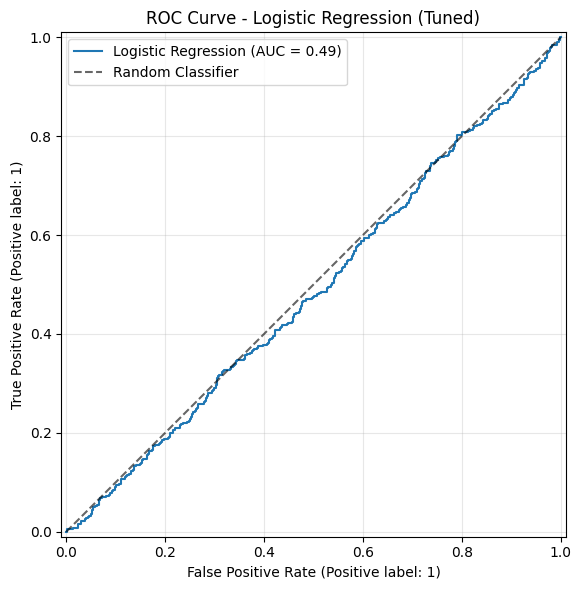

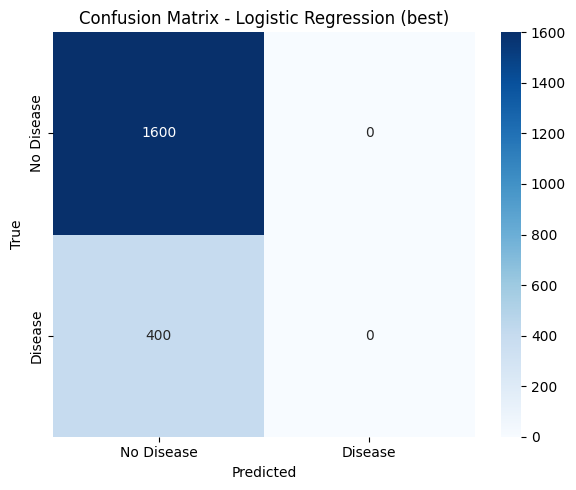


=== Classification Report (Best LR) ===
              precision    recall  f1-score   support

  No Disease      0.800     1.000     0.889      1600
     Disease      0.000     0.000     0.000       400

    accuracy                          0.800      2000
   macro avg      0.400     0.500     0.444      2000
weighted avg      0.640     0.800     0.711      2000


=== Top 100 Logistic Regression Konfiguracji (wg CV ROC-AUC) ===


,param_clf__C,param_clf__solver,param_clf__max_iter,param_clf__class_weight,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_accuracy
1,0.01,liblinear,500,None,0.513870,0.011654,1,0.000000,0.000000,0.000000,0.800000
2,0.01,lbfgs,500,balanced,0.513557,0.011010,2,0.205544,0.495000,0.290443,0.516375
3,0.01,liblinear,500,balanced,0.513499,0.010963,3,0.205548,0.495000,0.290447,0.516375
6,0.10,lbfgs,500,balanced,0.513329,0.011021,4,0.204475,0.493125,0.289061,0.514875
10,1.00,lbfgs,500,balanced,0.513301,0.011018,5,0.204571,0.493750,0.289265,0.514750
0,0.01,lbfgs,500,None,0.513288,0.011766,6,0.000000,0.000000,0.000000,0.800000
14,10.00,lbfgs,500,balanced,0.513287,0.011022,7,0.204571,0.493750,0.289265,0.514750
7,0.10,liblinear,500,balanced,0.513253,0.010952,8,0.204358,0.493125,0.288945,0.514625
11,1.00,liblinear,500,balanced,0.513216,0.010976,9,0.204735,0.493750,0.289429,0.515125
15,10.00,liblinear,500,balanced,0.513213,0.010972,10,0.204735,0.493750,0.289429,0.515125


In [ ]:
lr_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(random_state=RANDOM_STATE))
])

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1.0, 10],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__max_iter': [500],
    'clf__class_weight': [None, 'balanced']
}

grid_search_lr = GridSearchCV(
    lr_pipeline,
    param_grid=param_grid_lr,
    cv=5,
    scoring=['roc_auc', 'precision', 'recall', 'f1', 'accuracy'],
    refit='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train, y_train)

print(f"\nNajlepsze parametry Logistic Regression:")
print(f"  {grid_search_lr.best_params_}")
print(f"  Best CV ROC-AUC: {grid_search_lr.best_score_:.4f}")

best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)
y_prob_lr = best_lr_model.predict_proba(X_test)[:, 1]

print(f"\nTest Set Metrics (Best LR):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_lr, zero_division=0):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_lr, zero_division=0):.4f}")
print(f"  F1: {f1_score(y_test, y_pred_lr, zero_division=0):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_prob_lr, ax=ax, name='Logistic Regression')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Classifier')
ax.set_title('ROC Curve - Logistic Regression (Tuned)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    xticklabels=['No Disease', 'Disease'],
    yticklabels=['No Disease', 'Disease']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression (best)")
plt.tight_layout()
plt.show()

print("\n=== Classification Report (Best LR) ===")
print(classification_report(y_test, y_pred_lr, target_names=['No Disease', 'Disease'], digits=3, zero_division=0))

grid_results_lr = pd.DataFrame(grid_search_lr.cv_results_)
grid_results_lr_sorted = grid_results_lr[[
    'param_clf__C', 'param_clf__solver', 'param_clf__max_iter', 'param_clf__class_weight',
    'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc',
    'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_accuracy'
]].sort_values(by='rank_test_roc_auc')

print("\n=== Top 100 Logistic Regression Konfiguracji (wg CV ROC-AUC) ===")
display(grid_results_lr_sorted.head(100))

### K-Nearest Neighbors

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Najlepsze parametry KNN:
  {'clf__metric': 'euclidean', 'clf__n_neighbors': 9, 'clf__weights': 'uniform'}
  Best CV ROC-AUC: 0.5103

Test Set Metrics (Best KNN):
  Accuracy: 0.7840
  Precision: 0.1800
  Recall: 0.0225
  F1: 0.0400
  ROC-AUC: 0.4927


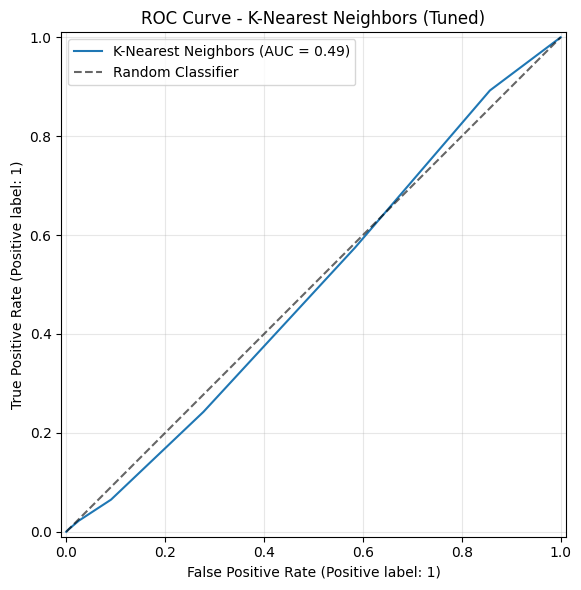

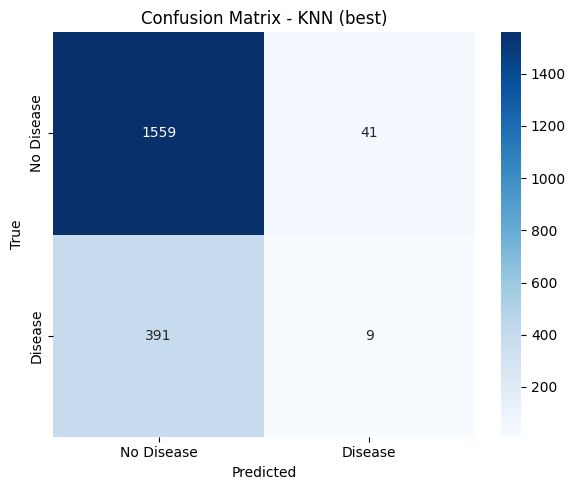


=== Classification Report (Best KNN) ===
              precision    recall  f1-score   support

  No Disease      0.799     0.974     0.878      1600
     Disease      0.180     0.022     0.040       400

    accuracy                          0.784      2000
   macro avg      0.490     0.498     0.459      2000
weighted avg      0.676     0.784     0.711      2000


=== Top 100 KNN Konfiguracji (wg CV ROC-AUC) ===


,param_clf__n_neighbors,param_clf__weights,param_clf__metric,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_accuracy
2,9,uniform,euclidean,0.510310,0.013948,1,0.204149,0.021250,0.038431,0.787375
4,15,uniform,euclidean,0.510217,0.012668,2,0.254872,0.005625,0.010955,0.797750
5,15,distance,euclidean,0.509740,0.013638,3,0.250476,0.005625,0.010940,0.797625
3,9,distance,euclidean,0.508322,0.013430,4,0.212873,0.022500,0.040631,0.787625
7,5,distance,manhattan,0.507081,0.006661,5,0.192526,0.059375,0.090676,0.763125
8,9,uniform,manhattan,0.506520,0.014893,6,0.183316,0.016250,0.029765,0.788250
9,9,distance,manhattan,0.506409,0.012337,7,0.182922,0.016875,0.030822,0.788000
11,15,distance,manhattan,0.505912,0.008439,8,0.188889,0.005625,0.010892,0.796250
6,5,uniform,manhattan,0.505029,0.010734,9,0.191428,0.058125,0.089101,0.763500
10,15,uniform,manhattan,0.504671,0.008613,10,0.194697,0.005625,0.010903,0.796500


In [ ]:
knn_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", KNeighborsClassifier())
])

param_grid_knn = {
    'clf__n_neighbors': [5, 9, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(
    knn_pipeline,
    param_grid=param_grid_knn,
    cv=5,
    scoring=['roc_auc', 'precision', 'recall', 'f1', 'accuracy'],
    refit='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_knn.fit(X_train, y_train)

print(f"\nNajlepsze parametry KNN:")
print(f"  {grid_search_knn.best_params_}")
print(f"  Best CV ROC-AUC: {grid_search_knn.best_score_:.4f}")

best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
y_prob_knn = best_knn_model.predict_proba(X_test)[:, 1]

print(f"\nTest Set Metrics (Best KNN):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_knn, zero_division=0):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_knn, zero_division=0):.4f}")
print(f"  F1: {f1_score(y_test, y_pred_knn, zero_division=0):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_knn):.4f}")

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_prob_knn, ax=ax, name='K-Nearest Neighbors')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Classifier')
ax.set_title('ROC Curve - K-Nearest Neighbors (Tuned)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    xticklabels=['No Disease', 'Disease'],
    yticklabels=['No Disease', 'Disease']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - KNN (best)")
plt.tight_layout()
plt.show()

print("\n=== Classification Report (Best KNN) ===")
print(classification_report(y_test, y_pred_knn, target_names=['No Disease', 'Disease'], digits=3, zero_division=0))

grid_results_knn = pd.DataFrame(grid_search_knn.cv_results_)
grid_results_knn_sorted = grid_results_knn[[
    'param_clf__n_neighbors', 'param_clf__weights', 'param_clf__metric',
    'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc',
    'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_accuracy'
]].sort_values(by='rank_test_roc_auc')

print("\n=== Top 100 KNN Konfiguracji (wg CV ROC-AUC) ===")
display(grid_results_knn_sorted.head(100))

### Decision Tree

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Najlepsze parametry Decision Tree:
  {'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10}
  Best CV ROC-AUC: 0.5173

Test Set Metrics (Best DT):
  Accuracy: 0.5920
  Precision: 0.1858
  Recall: 0.3075
  F1: 0.2316
  ROC-AUC: 0.4668


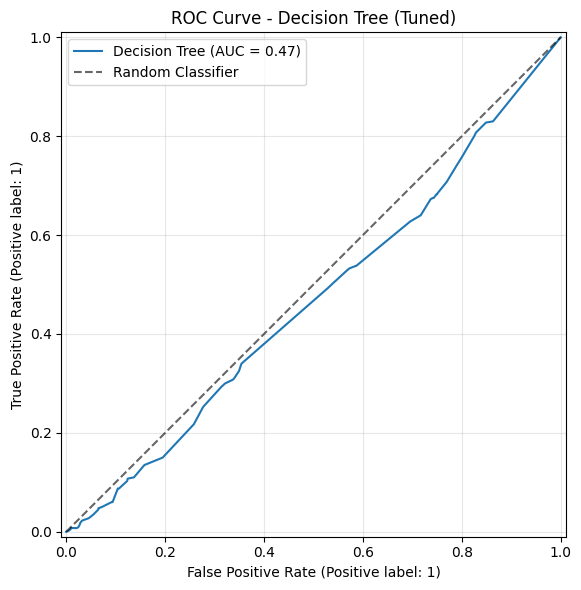

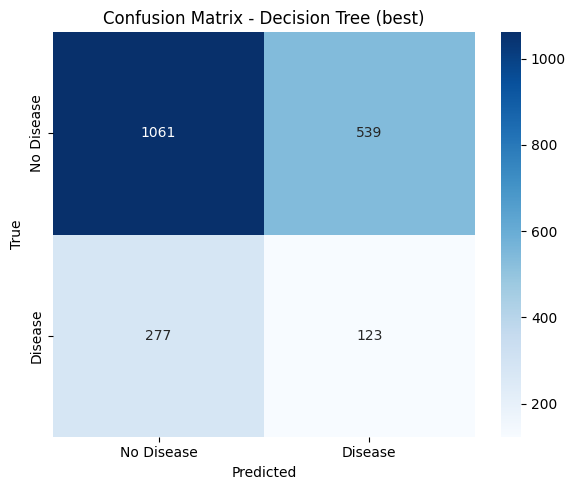


=== Classification Report (Best DT) ===
              precision    recall  f1-score   support

  No Disease      0.793     0.663     0.722      1600
     Disease      0.186     0.307     0.232       400

    accuracy                          0.592      2000
   macro avg      0.489     0.485     0.477      2000
weighted avg      0.672     0.592     0.624      2000


=== Top 100 Decision Tree Konfiguracji (wg CV ROC-AUC) ===


,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__class_weight,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_accuracy
7,gini,10,10,4,balanced,0.517342,0.014646,1,0.209094,0.510625,0.294007,0.512375
6,gini,10,2,4,balanced,0.516155,0.012281,2,0.208285,0.504375,0.291864,0.514750
4,gini,10,2,1,balanced,0.514983,0.024911,3,0.207061,0.486875,0.286715,0.523625
5,gini,10,10,1,balanced,0.514217,0.020353,4,0.207258,0.493125,0.288376,0.519000
19,entropy,10,10,4,balanced,0.511169,0.016718,5,0.213125,0.432500,0.274302,0.560750
17,entropy,10,10,1,balanced,0.510499,0.017259,6,0.212127,0.458125,0.278004,0.546625
16,entropy,10,2,1,balanced,0.508557,0.020801,7,0.210555,0.450000,0.274710,0.549750
22,entropy,None,2,4,balanced,0.508382,0.010800,8,0.205138,0.291875,0.240827,0.632000
18,entropy,10,2,4,balanced,0.507075,0.016907,9,0.210375,0.423750,0.270122,0.561375
11,gini,None,10,4,balanced,0.504970,0.014615,10,0.206758,0.321875,0.251736,0.617500


In [ ]:
dt_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_dt = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [5, 10, None],
    'clf__min_samples_split': [2, 10],
    'clf__min_samples_leaf': [1, 4],
    'clf__class_weight': ['balanced']
}

grid_search_dt = GridSearchCV(
    dt_pipeline,
    param_grid=param_grid_dt,
    cv=5,
    scoring=['roc_auc', 'precision', 'recall', 'f1', 'accuracy'],
    refit='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_dt.fit(X_train, y_train)

print(f"\nNajlepsze parametry Decision Tree:")
print(f"  {grid_search_dt.best_params_}")
print(f"  Best CV ROC-AUC: {grid_search_dt.best_score_:.4f}")

best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)
y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]

print(f"\nTest Set Metrics (Best DT):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_dt, zero_division=0):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_dt, zero_division=0):.4f}")
print(f"  F1: {f1_score(y_test, y_pred_dt, zero_division=0):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_dt):.4f}")

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_prob_dt, ax=ax, name='Decision Tree')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Classifier')
ax.set_title('ROC Curve - Decision Tree (Tuned)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    xticklabels=['No Disease', 'Disease'],
    yticklabels=['No Disease', 'Disease']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Decision Tree (best)")
plt.tight_layout()
plt.show()

print("\n=== Classification Report (Best DT) ===")
print(classification_report(y_test, y_pred_dt, target_names=['No Disease', 'Disease'], digits=3, zero_division=0))

grid_results_dt = pd.DataFrame(grid_search_dt.cv_results_)
grid_results_dt_sorted = grid_results_dt[[
    'param_clf__criterion', 'param_clf__max_depth', 'param_clf__min_samples_split',
    'param_clf__min_samples_leaf', 'param_clf__class_weight',
    'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc',
    'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_accuracy'
]].sort_values(by='rank_test_roc_auc')

print("\n=== Top 100 Decision Tree Konfiguracji (wg CV ROC-AUC) ===")
display(grid_results_dt_sorted.head(100))

### Gradient Boosting

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Najlepsze parametry Gradient Boosting:
  {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
  Best CV ROC-AUC: 0.5164

Test Set Metrics (Best GB):
  Accuracy: 0.8000
  Precision: 0.5000
  Recall: 0.0025
  F1: 0.0050
  ROC-AUC: 0.4844


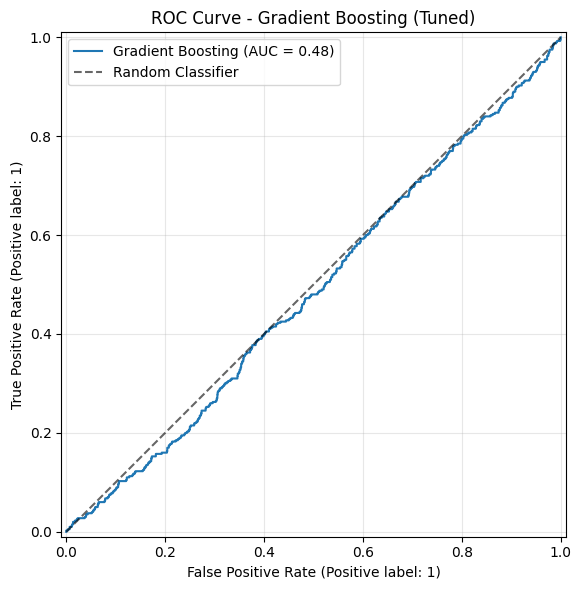

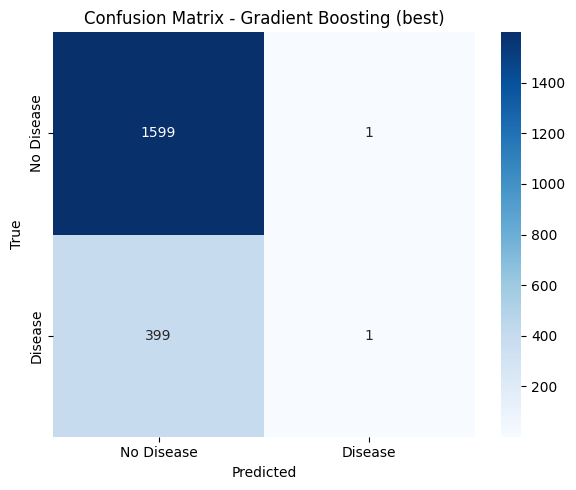


=== Classification Report (Best GB) ===
              precision    recall  f1-score   support

  No Disease      0.800     0.999     0.889      1600
     Disease      0.500     0.003     0.005       400

    accuracy                          0.800      2000
   macro avg      0.650     0.501     0.447      2000
weighted avg      0.740     0.800     0.712      2000


=== Top 100 Gradient Boosting Konfiguracji (wg CV ROC-AUC) ===


,param_clf__n_estimators,param_clf__learning_rate,param_clf__max_depth,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__subsample,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_accuracy
18,100,0.10,3,10,1,1.0,0.516418,0.008951,1,0.100000,0.000625,0.001242,0.799125
0,100,0.05,3,2,1,1.0,0.515690,0.007522,2,0.200000,0.000625,0.001246,0.800000
1,200,0.05,3,2,1,1.0,0.515246,0.005859,3,0.100000,0.000625,0.001242,0.799500
12,100,0.05,4,2,4,1.0,0.514184,0.010884,4,0.133333,0.001250,0.002477,0.799625
2,100,0.05,3,10,1,1.0,0.514073,0.006493,5,0.000000,0.000000,0.000000,0.799750
3,200,0.05,3,10,1,1.0,0.513296,0.010216,6,0.000000,0.000000,0.000000,0.798875
4,100,0.05,3,2,4,1.0,0.513024,0.003227,7,0.000000,0.000000,0.000000,0.799875
6,100,0.05,3,10,4,1.0,0.512990,0.003730,8,0.000000,0.000000,0.000000,0.800000
19,200,0.10,3,10,1,1.0,0.512733,0.008411,9,0.200000,0.004375,0.008552,0.797375
7,200,0.05,3,10,4,1.0,0.511610,0.006683,10,0.133333,0.001250,0.002477,0.799500


In [ ]:
gb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

param_grid_gb = {
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [3, 4],
    'clf__min_samples_split': [2, 10],
    'clf__min_samples_leaf': [1, 4],
    'clf__subsample': [1.0]
}

grid_search_gb = GridSearchCV(
    gb_pipeline,
    param_grid=param_grid_gb,
    cv=5,
    scoring=['roc_auc', 'precision', 'recall', 'f1', 'accuracy'],
    refit='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train, y_train)

print(f"\nNajlepsze parametry Gradient Boosting:")
print(f"  {grid_search_gb.best_params_}")
print(f"  Best CV ROC-AUC: {grid_search_gb.best_score_:.4f}")

best_gb_model = grid_search_gb.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)
y_prob_gb = best_gb_model.predict_proba(X_test)[:, 1]

print(f"\nTest Set Metrics (Best GB):")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_gb, zero_division=0):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_gb, zero_division=0):.4f}")
print(f"  F1: {f1_score(y_test, y_pred_gb, zero_division=0):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_gb):.4f}")

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_prob_gb, ax=ax, name='Gradient Boosting')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Classifier')
ax.set_title('ROC Curve - Gradient Boosting (Tuned)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    xticklabels=['No Disease', 'Disease'],
    yticklabels=['No Disease', 'Disease']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Gradient Boosting (best)")
plt.tight_layout()
plt.show()

print("\n=== Classification Report (Best GB) ===")
print(classification_report(y_test, y_pred_gb, target_names=['No Disease', 'Disease'], digits=3, zero_division=0))

grid_results_gb = pd.DataFrame(grid_search_gb.cv_results_)
grid_results_gb_sorted = grid_results_gb[[
    'param_clf__n_estimators', 'param_clf__learning_rate', 'param_clf__max_depth',
    'param_clf__min_samples_split', 'param_clf__min_samples_leaf', 'param_clf__subsample',
    'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc',
    'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_accuracy'
]].sort_values(by='rank_test_roc_auc')

print("\n=== Top 100 Gradient Boosting Konfiguracji (wg CV ROC-AUC) ===")
display(grid_results_gb_sorted.head(100))

### Neural Network

Trenowanie: nn_1layer...
  Test Loss: 0.6862, Test AUC: 0.4677, ROC-AUC: 0.4683

Trenowanie: nn_2layer...
  Test Loss: 0.6927, Test AUC: 0.4828, ROC-AUC: 0.4827

Trenowanie: nn_3layer...
  Test Loss: 0.7113, Test AUC: 0.4973, ROC-AUC: 0.4968

=== Porównanie architektur Neural Network ===


,architecture,test_loss,test_accuracy,test_auc,precision,recall,f1,roc_auc
2,nn_3layer,0.711315,0.379,0.497306,0.200142,0.7025,0.311530,0.496770
1,nn_2layer,0.692733,0.508,0.482828,0.190021,0.4475,0.266766,0.482723
0,nn_1layer,0.686241,0.527,0.467717,0.172662,0.3600,0.233387,0.468268


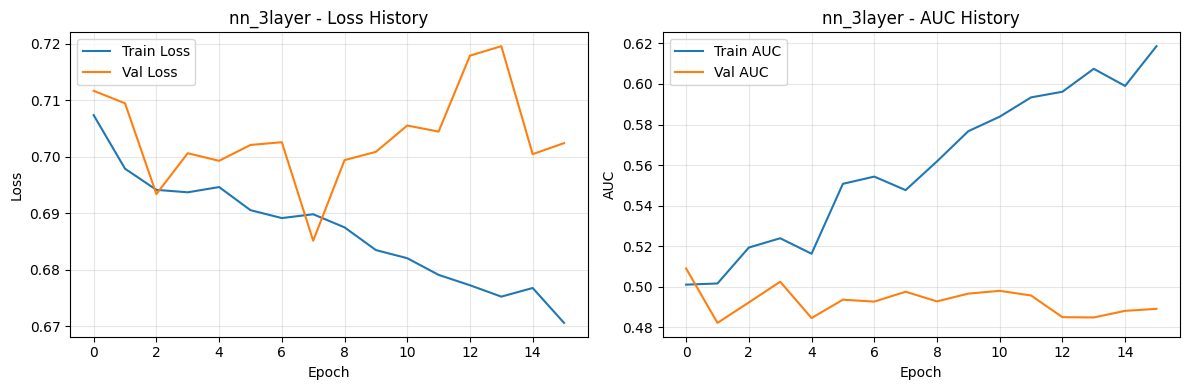

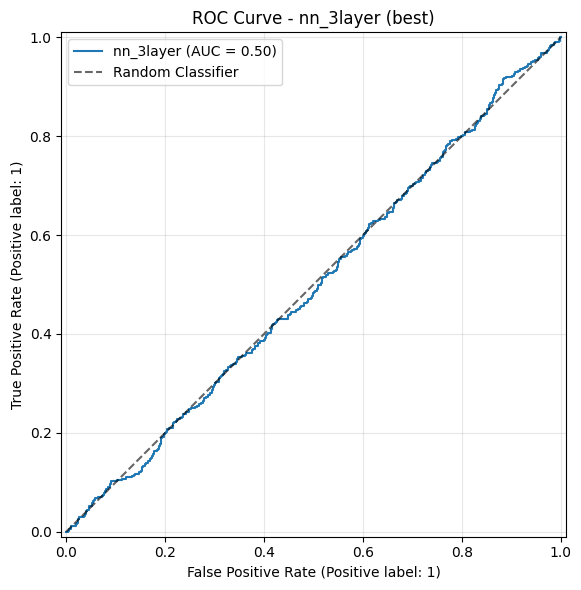

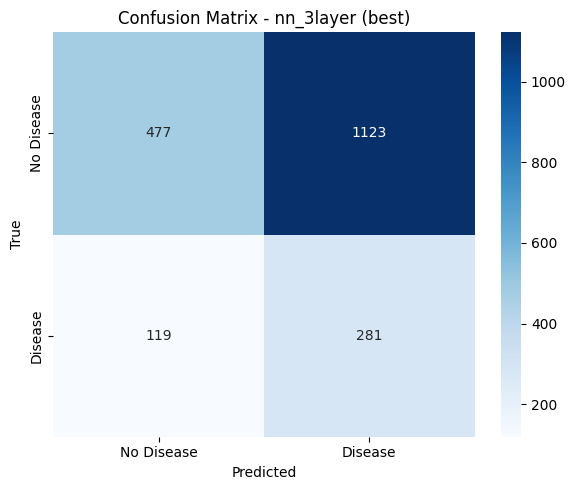


=== Classification Report (Best NN) ===
              precision    recall  f1-score   support

  No Disease      0.800     0.298     0.434      1600
     Disease      0.200     0.703     0.312       400

    accuracy                          0.379      2000
   macro avg      0.500     0.500     0.373      2000
weighted avg      0.680     0.379     0.410      2000


Najlepsza architektura: nn_3layer (ROC-AUC: 0.4968)


In [15]:
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc = preprocess.transform(X_test)

if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}

cb = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=15,
    restore_best_weights=True,
    mode='max'
)

def create_mlp_1layer(input_dim):
    """1 warstwa ukryta (16 neuronów)"""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.AUC(name='auc')])
    return model

def create_mlp_2layer(input_dim):
    """2 warstwy ukryte (64 -> 32)"""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.AUC(name='auc')])
    return model

def create_mlp_3layer(input_dim):
    """3 warstwy ukryte (64 -> 32 -> 16)"""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.AUC(name='auc')])
    return model

nn_configs = {
    "nn_1layer": create_mlp_1layer,
    "nn_2layer": create_mlp_2layer,
    "nn_3layer": create_mlp_3layer
}

input_dim = X_train_proc.shape[1]
nn_results = []

for config_name, create_func in nn_configs.items():
    print(f"Trenowanie: {config_name}...")

    model = create_func(input_dim)

    history = model.fit(
        X_train_proc, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[cb],
        verbose=0
    )

    results = model.evaluate(X_test_proc, y_test, verbose=0)

    y_pred_nn = (model.predict(X_test_proc, verbose=0) > 0.5).astype(int).flatten()
    y_prob_nn = model.predict(X_test_proc, verbose=0).flatten()

    nn_results.append({
        "architecture": config_name,
        "test_loss": results[0],
        "test_accuracy": results[1],
        "test_auc": results[2],
        "precision": precision_score(y_test, y_pred_nn, zero_division=0),
        "recall": recall_score(y_test, y_pred_nn, zero_division=0),
        "f1": f1_score(y_test, y_pred_nn, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_prob_nn),
        "y_pred": y_pred_nn,
        "y_prob": y_prob_nn,
        "model": model,
        "history": history
    })

    print(f"  Test Loss: {results[0]:.4f}, Test AUC: {results[2]:.4f}, ROC-AUC: {roc_auc_score(y_test, y_prob_nn):.4f}\n")

nn_results_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['model', 'history', 'y_pred', 'y_prob']} for r in nn_results])
nn_results_df = nn_results_df.sort_values(by="roc_auc", ascending=False)

print("=== Porównanie architektur Neural Network ===")
display(nn_results_df)

best_nn_idx = nn_results_df.index[0]
best_nn_result = nn_results[best_nn_idx]
best_history = best_nn_result['history']
best_y_pred = best_nn_result['y_pred']
best_y_prob = best_nn_result['y_prob']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(best_history.history['loss'], label='Train Loss')
axes[0].plot(best_history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'{best_nn_result["architecture"]} - Loss History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(best_history.history['auc'], label='Train AUC')
axes[1].plot(best_history.history['val_auc'], label='Val AUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title(f'{best_nn_result["architecture"]} - AUC History')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, best_y_prob, ax=ax, name=best_nn_result['architecture'])
ax.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random Classifier')
ax.set_title(f"ROC Curve - {best_nn_result['architecture']} (best)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    xticklabels=['No Disease', 'Disease'],
    yticklabels=['No Disease', 'Disease']
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {best_nn_result['architecture']} (best)")
plt.tight_layout()
plt.show()

print("\n=== Classification Report (Best NN) ===")
print(classification_report(y_test, best_y_pred, target_names=['No Disease', 'Disease'], digits=3, zero_division=0))

print(f"\nNajlepsza architektura: {best_nn_result['architecture']} (ROC-AUC: {best_nn_result['roc_auc']:.4f})")

In [16]:
models = [
    {
        "name": "RandomForest",
        "estimator": best_rf_model,
        "y_pred": y_pred_rf,
        "y_prob": y_prob_rf
    },
    {
        "name": "Logistic Regression",
        "estimator": best_lr_model,
        "y_pred": y_pred_lr,
        "y_prob": y_prob_lr
    },
    {
        "name": "KNN",
        "estimator": best_knn_model,
        "y_pred": y_pred_knn,
        "y_prob": y_prob_knn
    },
    {
        "name": "Decision Tree",
        "estimator": best_dt_model,
        "y_pred": y_pred_dt,
        "y_prob": y_prob_dt
    },
    {
        "name": "Gradient Boosting",
        "estimator": best_gb_model,
        "y_pred": y_pred_gb,
        "y_prob": y_prob_gb
    },
    {
        "name": best_nn_result["architecture"],
        "estimator": best_nn_result["model"],
        "y_pred": best_y_pred,
        "y_prob": best_y_prob
    }
]

summary_rows = []
for m in models:
    summary_rows.append({
        "model": m["name"],
        "accuracy": accuracy_score(y_test, m["y_pred"]),
        "precision": precision_score(y_test, m["y_pred"], zero_division=0),
        "recall": recall_score(y_test, m["y_pred"], zero_division=0),
        "f1": f1_score(y_test, m["y_pred"], zero_division=0),
        "roc_auc": roc_auc_score(y_test, m["y_prob"]),
        "estimator": m["estimator"]
    })

results_summary = pd.DataFrame(summary_rows).sort_values(by="roc_auc", ascending=False).reset_index(drop=True)

print("=== Zestawienie modeli (sortowane po ROC-AUC) ===")
display(results_summary[["model", "accuracy", "precision", "recall", "f1", "roc_auc"]])

best_overall = results_summary.iloc[0]
best_overall_model_name = best_overall["model"]
best_overall_estimator = best_overall["estimator"]

tree_like = results_summary[results_summary["model"].isin(["RandomForest", "Decision Tree", "Gradient Boosting"])]
if not tree_like.empty:
    best_tree_row = tree_like.iloc[0]
    best_model_name = best_tree_row["model"]
    best_model = best_tree_row["estimator"]
else:
    best_model_name = best_overall_model_name
    best_model = best_overall_estimator

print(f"\nNajlepszy model ogólnie: {best_overall_model_name} (ROC-AUC: {best_overall['roc_auc']:.4f}, F1: {best_overall['f1']:.4f})")
print(f"Model do interpretacji SHAP: {best_model_name}")

=== Zestawienie modeli (sortowane po ROC-AUC) ===


,model,accuracy,precision,recall,f1,roc_auc
0,nn_3layer,0.3790,0.200142,0.7025,0.311530,0.496770
1,KNN,0.7840,0.180000,0.0225,0.040000,0.492686
2,Logistic Regression,0.8000,0.000000,0.0000,0.000000,0.486411
3,Gradient Boosting,0.8000,0.500000,0.0025,0.004975,0.484424
4,RandomForest,0.5375,0.181045,0.3725,0.243663,0.471320
5,Decision Tree,0.5920,0.185801,0.3075,0.231638,0.466849



Najlepszy model ogólnie: nn_3layer (ROC-AUC: 0.4968, F1: 0.3115)
Model do interpretacji SHAP: Gradient Boosting


## 11. Interpretowalność - znaczenie cech i SHAP

=== Feature Importances - Gradient Boosting ===

Top 20 najważniejszych cech:
                       feature  importance
3                          BMI    0.192238
8           Homocysteine Level    0.146038
0                          Age    0.107970
4                  Sleep Hours    0.094268
7                    CRP Level    0.088846
6          Fasting Blood Sugar    0.087706
2            Cholesterol Level    0.069102
5           Triglyceride Level    0.048625
1               Blood Pressure    0.047992
31         Stress Level_Medium    0.025876
30            Stress Level_Low    0.016009
34    Sugar Consumption_Medium    0.012704
28  Alcohol Consumption_Medium    0.009102
27     Alcohol Consumption_Low    0.008343
9                Gender_Female    0.008311
14                  Smoking_No    0.006528
26    Alcohol Consumption_High    0.004860
18                 Diabetes_No    0.004303
15                 Smoking_Yes    0.004182
32      Sugar Consumption_High    0.003973


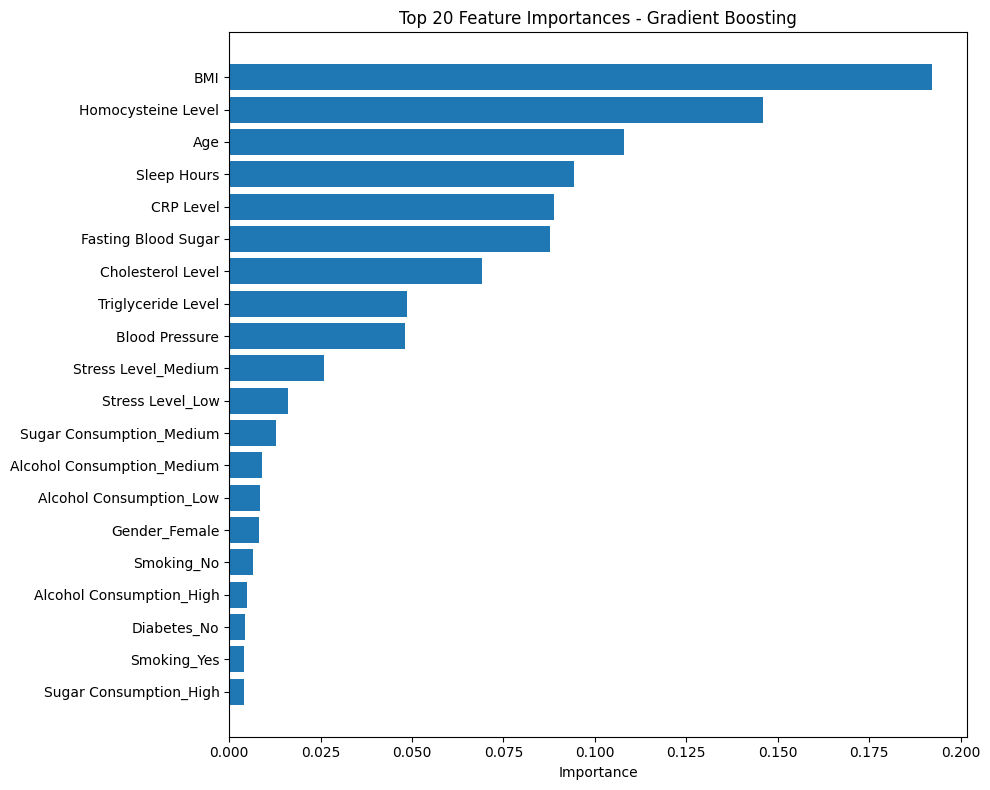


=== Analiza SHAP ===
Generowanie wykresów SHAP (używając 200 próbek dla szybkości)...


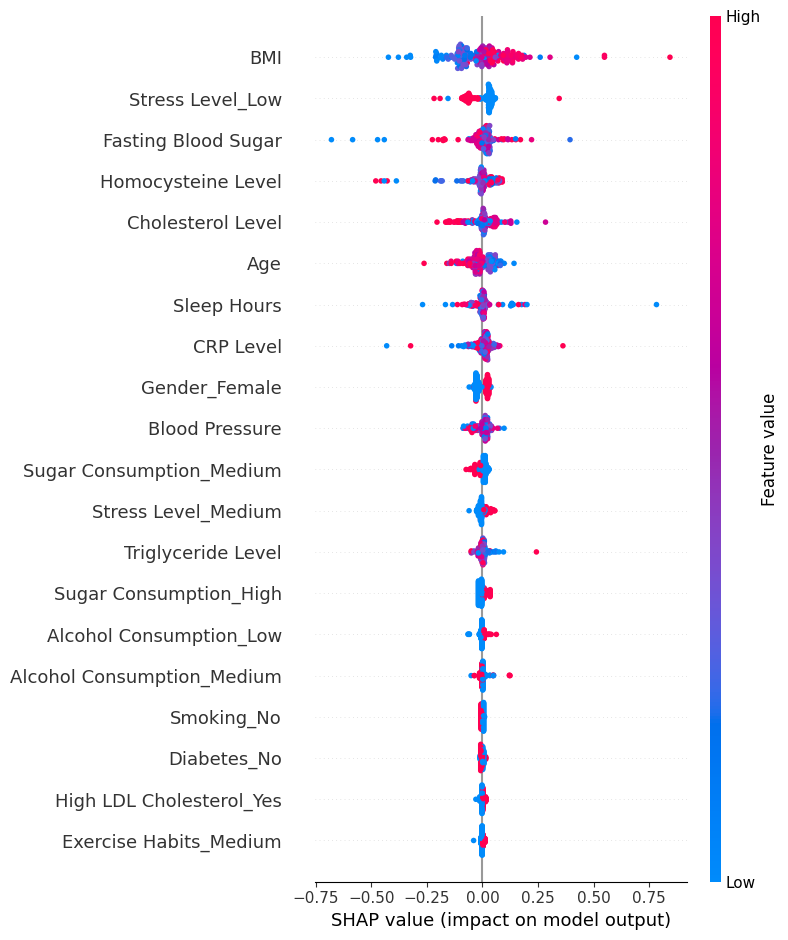

In [17]:
def get_feature_names(preprocessor):
    """Zwraca listę nazw po one-hot i skalowaniu."""
    num_features = preprocessor.named_transformers_["num"].get_feature_names_out(num_cols)
    cat_features = preprocessor.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(cat_cols)
    return np.concatenate([num_features, cat_features])

print(f"=== Feature Importances - {best_model_name} ===")
feature_names = get_feature_names(preprocess)
importances = best_model.named_steps["clf"].feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 20 najważniejszych cech:")
print(imp_df.head(20))

plt.figure(figsize=(10, 8))
top_features = imp_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title(f'Top 20 Feature Importances - {best_model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n=== Analiza SHAP ===")
print("Generowanie wykresów SHAP (używając 200 próbek dla szybkości)...")

X_test_sample = X_test.sample(n=200, random_state=RANDOM_STATE)
y_test_sample = y_test.loc[X_test_sample.index]

X_test_transformed = best_model.named_steps["preprocess"].transform(X_test_sample)

explainer = shap.TreeExplainer(best_model.named_steps["clf"])
shap_values = explainer.shap_values(X_test_transformed)

plt.figure(figsize=(10, 8))
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_test_transformed, feature_names=feature_names, show=False)
else:
    shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

## 11. Wyniki

1. **Zakres oceny i metodologia**
   - Modele oceniono na zbiorze testowym po w walidacji krzyżowej w ramach GridSearchCV
   - Raportowane metryki to accuracy, precision, recall, F1 i ROC-AUC liczone przy standardowym progu 0,5
2. **Porównanie modeli (ranking)**
   - RF, LR, KNN, DT, GB oraz MLP osiągają bardzo zbliżone wyniki, brak wyraźnego lidera
   - Różnice między konfiguracjami są niewielkie i często mieszczą się w odchyleniach CV, co sugeruje niestabilność rankingu
3. **Metryki klasyfikacji**
   - Accuracy utrzymuje się blisko poziomu bazowego
   - Precision/recall/F1 są niskie, macierze pomyłek pokazują wiele FP i FN bez przewagi dla którejkolwiek klasy
4. **Krzywe ROC-AUC**
   - Krzywe ROC przebiegają blisko przekątnej, a ROC-AUC oscyluje w okolicach 0,5
   - Brak zakresu progów, który zapewniałby sensowny kompromis między czułością a swoistością
5. **Sieci neuronowe**
   - Testowane architektury nie poprawiają jakości predykcji względem modeli klasycznych
   - Pomimo early stopping i wag klas AUC pozostaje zbliżone do losowego
6. **Interpretowalność**
   - Nie widać stabilnych, dominujących cech, wkład cech jest rozproszony
   - Sugeruje to słaby sygnał w danych lub zależności przypadkowe
7. **Ograniczenia danych**
   - Wyraźna niska jakość etykiet, niewystarczająca liczba próbek oraz brak cech o wysokiej wartości informacyjnej
   - Drobne różnice w wynikach mogą wynikać z losowości próbkowania, a nie z realnej poprawy modeli
8. **Znaczenie praktyczne**
   - W obecnej postaci modele nie są gotowe do zastosowań praktycznych ani wnioskowania klinicznego
   - Ryzyko błędnych decyzji jest zbyt wysokie przy tak słabej jakości predykcji
9. **Możliwe dalsze kroki**
   - Poprawa jakości i spójności etykiet, zwiększenie liczby obserwacji oraz wzbogacenie cech
   - Dopiero po wzmocnieniu sygnału w danych warto wracać do strojenia modeli